In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_context('talk')

# Data Preparation

In [2]:
df_raw = pd.read_csv("online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [3]:
df_raw.iloc[0]

Invoice                                     489434
StockCode                                    85048
Description    15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                        12
InvoiceDate                    2009-12-01 07:45:00
Price                                         6.95
Customer ID                                13085.0
Country                             United Kingdom
Name: 0, dtype: object

In [7]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

In [148]:
df_raw['invoice_date_week'] = pd.to_datetime(
    pd.to_datetime(df_raw['InvoiceDate']) - pd.to_timedelta(df_raw['InvoiceDate'].dt.dayofweek, unit='d')
)#.dt.date

In [131]:
pd.to_timedelta(df_raw['InvoiceDate'].dt.dayofweek, unit='d')

0         1 days
1         1 days
2         1 days
3         1 days
4         1 days
           ...  
1067366   4 days
1067367   4 days
1067368   4 days
1067369   4 days
1067370   4 days
Name: InvoiceDate, Length: 1067371, dtype: timedelta64[ns]

In [ ]:
from pandas.tseries.offsets import MonthEnd

df_raw['month_end_date'] = df_raw['InvoiceDate'] + MonthEnd(1)

In [6]:
print(f"Number of unique item codes: {df_raw['StockCode'].nunique():,}")

Number of unique item codes: 5,305


In [19]:
agg_date = df_raw.groupby(['StockCode']).agg({
    'invoice_date_week': ['min','max','nunique']
}).reset_index()

agg_date.columns = [
    col[0] if col[1] == '' else col[0]+'_'+col[1] for col in agg_date.columns
]

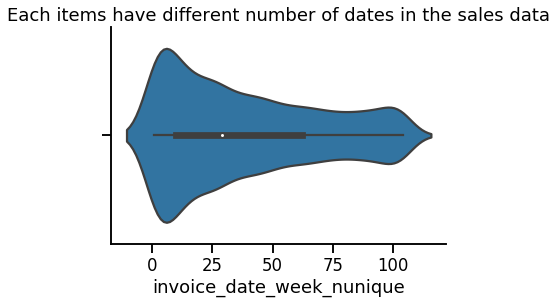

In [25]:
sns.violinplot(agg_date['invoice_date_week_nunique'])
plt.title('Each item has a different number of dates in the sales data')
sns.despine();

In [26]:
df_raw['Quantity'].describe()

count    1.067371e+06
mean     9.938898e+00
std      1.727058e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64

In [30]:
negative_quantity = (df_raw['Quantity'] < 0).sum() / df_raw.shape[0] 
print(f"{negative_quantity:.2%} of the records have negative sales quantity")

2.15% of the records have negative sales quantity


Interesting -- the total sales quantity can be extremely negative. To simplify, we'll only take items with positive all-time sales quantity.

In [33]:
agg_quantity = df_raw.groupby('StockCode').sum()['Quantity'].sort_values().reset_index()
agg_quantity.head()

,StockCode,Quantity
0,20852,-18800
1,22126,-16400
2,23005,-14418
3,23003,-8516
4,10120,-8350


In [42]:
positive_quantity_item_list = agg_quantity.query('Quantity > 0')['StockCode'].tolist()
df_selected = df_raw.query('StockCode in @positive_quantity_item_list')

# Observe sales history

In [150]:
df_selected.iloc[0]

Invoice                                           489434
StockCode                                          85048
Description          15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                              12
InvoiceDate                          2009-12-01 07:45:00
Price                                               6.95
Customer ID                                        13085
Country                                   United Kingdom
subtotal                                            83.4
invoice_date_week                             2009-11-30
Name: 0, dtype: object

In [156]:
# df_selected.groupby(pd.Grouper(key='invoice_date_week', freq='W'))

In [149]:
df_agg = df_selected.groupby([
    pd.Grouper(
        key='invoice_date_week',
        freq='W'
    ),
    'StockCode'
]).sum()['Quantity'].reset_index().rename(
    columns={
        'StockCode': 'stock_code',
        'Quantity': 'quantity'
    }
)

df_agg.head()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

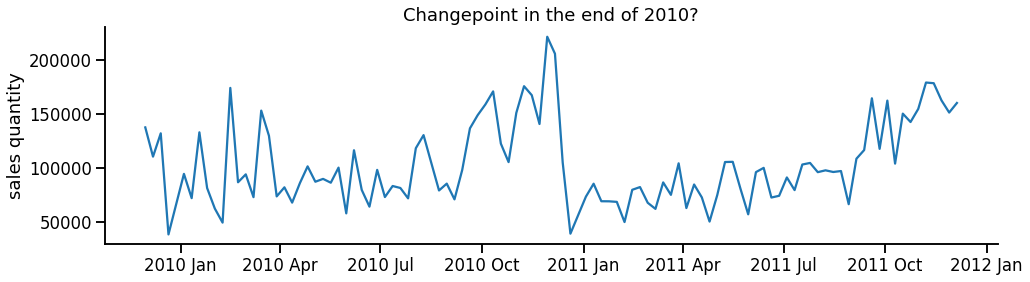

In [54]:
f, ax = plt.subplots(figsize=(16, 4))

df_agg.groupby('invoice_date_week').sum()['quantity'].plot.line();

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax.set_xlabel('')
ax.set_ylabel('sales quantity')
plt.title("Changepoint in the end of 2010?")
sns.despine();

## Generate complete time series

In [129]:
from datetime import date

current_date = pd.to_datetime(date.today())
current_month_end_date = current_date.to_period("M").to_timestamp("M")

def ensure_complete_date(
    df,
    date_column,
    latest_date_sequence=None,
    value_columns=["quantity"],
    grouping_columns=None,
    is_date_index=False,
    date_freq="D",
    impute_missing=True,
    impute_method="linear",
    impute_method_param=2,
):
    """
    Ensure all dates exist in the dataset.
    If there are any missing dates, a full period will be generated.
    If impute_missing is True, missing values will be imputed, by default via linear interpolation.
    If impute_missing is False, missing values will be filled by 0.
    If grouping_columns are specified, we expect to get a dataframe that contains only one group as input.
    i.e., please use this function in conjunction with df.iterrows() -- loop over each group in your main function
    Check pandas.DataFrame.interpolate() for more reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    Return a dataframe with complete dates.
    """
    if is_date_index:
        date_min = df.index.min()
        date_max = df.index.max()
    else:
        date_min = df[date_column].min()
        date_max = df[date_column].max()
        ## ensure df[date_column] has the same data type as date_sequence
        df[date_column] = pd.to_datetime(df[date_column])

    ## if grouping_columns is specified
    ## take the max date of all groups (to ensure each group has full records until the latest date)
    if latest_date_sequence is not None:
        date_max = max(date_max, latest_date_sequence)

    date_sequence = pd.date_range(start=date_min, end=date_max, freq=date_freq)

    ## check if any dates are missing from the generated date sequence
    if is_date_index:
        missing_date_count = (~date_sequence.isin(df.index)).sum()
    else:
        missing_date_count = (~date_sequence.isin(df[date_column])).sum()

    ## impute value, can be moved as another function?
    if missing_date_count > 0:
        print("There are missing dates in the dataframe. Full period is generated.")
        df_full = pd.DataFrame(data={"period_date": date_sequence})
        if grouping_columns is None:
            if is_date_index:
                df_full = df_full.merge(
                    df, how="left", left_on="period_date", right_index=True
                )
            else:
                df_full = df_full.merge(
                    df, how="inner", left_on="period_date", right_on=date_column
                )
        else:
            df = df.reset_index()
            if is_date_index:
                df_full = df_full.merge(
                    df[[date_column] + grouping_columns + value_columns],
                    how="left",
                    left_on="period_date",
                    right_index=True,
                )
            else:
                df_full = df_full.merge(
                    df[[date_column] + grouping_columns + value_columns],
                    how="left",
                    left_on="period_date",
                    right_on=date_column,
                )
                
            ## fill NA in grouping column
            for group_col in grouping_columns:
                fill_value = df[group_col].unique()[0]
                ## ensure the filled value is not na
                assert fill_value is not np.nan
                df_full[group_col].fillna(fill_value, inplace=True)

        display(df.head())
        display(df_full.head())
        
        ## impute value, either using interpolation or zero
        if impute_missing:
            for col in value_columns:
                if impute_method in ["polynomial", "spline"]:
                    df_full[["period_date", col]] = df_full[
                        ["period_date", col]
                    ].interpolate(method=impute_method, order=impute_method_param)
                else:
                    df_full[["period_date", col]] = df_full[
                        ["period_date", col]
                    ].interpolate(method=impute_method)
        else:
            for col in value_columns:
                df_full[col].fillna(0, inplace=True)
        return df_full
    else:
        return df


def generate_complete_records(
    df,
    main_grouping_columns=["stock_code"],
    date_columns=["invoice_date_week"],
    main_date_column="invoice_date_week",
    value_columns=["quantity"],
    date_freq="M",
    latest_date_sequence=None,
    impute_missing: str = False,
    impute_method: str = "linear",
    impute_method_param: int = 2,
):
    """
    Ensure all records (based on grouping columns) have complete records from their first date until the most recent date.
    """
    ## ensure grouping columns exist in the dm
    assert all(col in df.columns for col in main_grouping_columns)
    assert (
        main_grouping_columns == ["stock_code"]
    )
    assert main_date_column in date_columns

    ## ensure all dates exist for each item_code and segment, starting from the first transaction date
    ## using df.iterrows() may not be the best solution
    ## have tried using df.groupby(grouping_columns).apply(ensure_complete_date, *kwargs)
    ## but the operation is executed per row, not per grouped df

    df_unique_group_columns = df[main_grouping_columns].drop_duplicates()
    df_full = pd.DataFrame()

    for idx, row in df_unique_group_columns.iterrows():
        ## if the grouping columns are only ['item_code'],
        ## the logic for mask rows are different
        mask = df["stock_code"] == row["stock_code"]

        df_masked = df[mask].copy()
        if latest_date_sequence is None:
            max_date = df[main_date_column].max()
        else:
            max_date = current_month_end_date

        df_temp = ensure_complete_date(
            df_masked,
            date_column=main_date_column,
            value_columns=value_columns,
            grouping_columns=main_grouping_columns,
            ## to ensure all records are generated until the latest date
            latest_date_sequence=max_date,
            date_freq=date_freq,
            impute_missing=impute_missing,
            impute_method=impute_method,
            impute_method_param=impute_method_param,
        )
        df_full = pd.concat([df_full, df_temp])

    ## remove additional columns that are generated from ensure_complete_date()
    ## it is added only if there are missing dates
    if "period_date" in df_full.columns:
        conditions = [df_full["period_date"].isnull()]
        choices = [df_full[main_date_column]]
        df_full["period_date"] = np.select(
            conditions, choices, default=df_full["period_date"]
        )

        df_full = df_full.drop(labels=date_columns, axis=1).rename(
            columns={"period_date": main_date_column}
        )
    
    return df_full.reset_index(drop=True)

In [130]:
## TO DO: figure out why the series have 0 quantity
GENERATE_SERIES = True #False
SERIES_FILE_NAME = 'weekly-item-full-series.csv'

if GENERATE_SERIES:
#     df_agg_full = generate_complete_records(df=df_agg, date_freq='W')    
    df_agg_full = generate_complete_records(df=df_agg.query('stock_code == "85123A"'), date_freq='W')    
#     df_agg_full.to_csv(SERIES_FILE_NAME, index=False)
else:
    df_agg_full = pd.read_csv(SERIES_FILE_NAME)

There are missing dates in the dataframe. Full period is generated.


,index,stock_code,invoice_date_week,quantity
0,184741,85123A,2009-11-30,1657
1,184742,85123A,2009-12-07,3139
2,184743,85123A,2009-12-14,1289
3,184744,85123A,2009-12-21,126
4,184745,85123A,2010-01-04,1767


,period_date,invoice_date_week,stock_code,quantity
0,2009-12-06,NaT,85123A,NaN
1,2009-12-13,NaT,85123A,NaN
2,2009-12-20,NaT,85123A,NaN
3,2009-12-27,NaT,85123A,NaN
4,2010-01-03,NaT,85123A,NaN


In [128]:
df_agg_full.sum()['quantity']

0.0

In [116]:
df_agg_full.shape

(412655, 3)

In [117]:
df_agg_full['quantity'].sum()

0.0

## Observe new time series data

In [95]:
agg_quantity.tail()

,StockCode,Quantity
5300,84879,80705
5301,21212,95450
5302,85099B,95739
5303,85123A,96066
5304,84077,108545


In [106]:
df_agg.query('stock_code == @SELECTED_ITEM').sum()

stock_code    85123A85123A85123A85123A85123A85123A85123A8512...
quantity                                                  96066
dtype: object

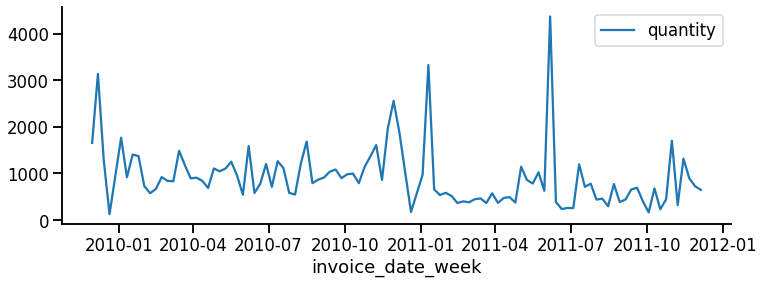

In [112]:
f, ax = plt.subplots(figsize=(12,4))

SELECTED_ITEM = '85123A'
df_agg.query('stock_code == @SELECTED_ITEM').plot.line(
    x='invoice_date_week', 
    y='quantity', 
    ax=ax
);
sns.despine();

# Clustering